# 라이브러리 확인

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()


#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
setattr(
    tfds.image_classification.cats_vs_dogs,
    '_URL',
    'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip')

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [ ]:
def normalize_and_resize_img(image, label):
    
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

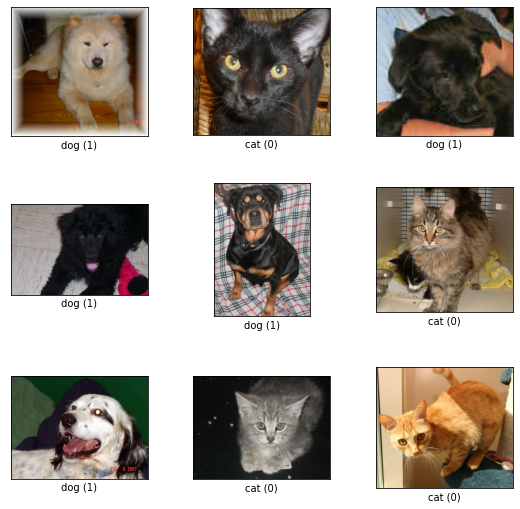

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

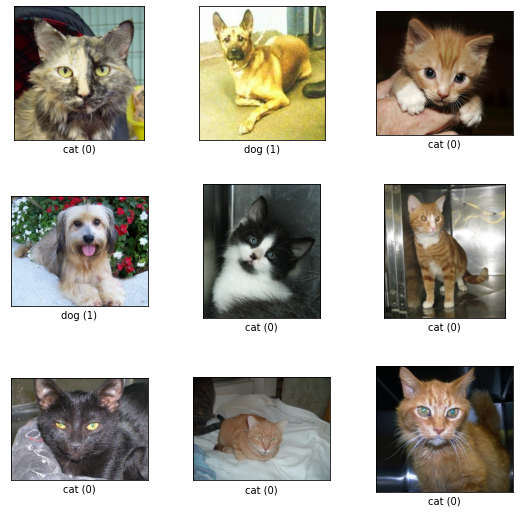

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

In [ ]:
ds_info.features["label"].num_classes

2

In [ ]:
ds_info.features["label"].names

['cat', 'dog']

# resnet block

In [ ]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

기본 값은 resnet-34로 되어있고 두가지 옵션이 있는데 이는 각각 이것을 의미한다.

is_50 : resnet 50을 사용할지 안할지를 정하는 bool 변수

is_plain : skip connection을 사용할지 안할지를 정하는 bool 변수이다.

# resnet builder


In [ ]:
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [ ]:
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  832         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 112, 112, 64  832         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 112, 112, 64  256        ['conv2d_4[0][0]']               
 ormalization)                  )                                                           

In [ ]:
BATCH_SIZE = 64
EPOCH = 30

In [ ]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# 모델 학습

Resnet 모델

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 88s 226ms/step - loss: 1.5387 - accuracy: 0.5721 - val_loss: 1.6679 - val_accuracy: 0.4749
Epoch 2/30
290/290 [==============================] - 61s 210ms/step - loss: 1.0220 - accuracy: 0.6253 - val_loss: 1.1222 - val_accuracy: 0.5530
Epoch 3/30
290/290 [==============================] - 61s 210ms/step - loss: 0.7556 - accuracy: 0.6703 - val_loss: 0.7279 - val_accuracy: 0.6878
Epoch 4/30
290/290 [==============================] - 61s 211ms/step - loss: 0.6172 - accuracy: 0.7025 - val_loss: 0.6693 - val_accuracy: 0.6933
Epoch 5/30
290/290 [==============================] - 61s 210ms/step - loss: 0.5078 - accuracy: 0.7540 - val_loss: 0.7036 - val_accuracy: 0.6539
Epoch 6/30
290/290 [==============================] - 61s 210ms/step - loss: 0.4522 - accuracy: 0.7867 - val_loss: 0.5252 - val_accuracy: 0.7658
Epoch 7/30
290/290 [==============================] - 61s 209ms/step - loss: 0.4098 - accuracy: 0.8107 - val_loss: 0.5338 - val_accuracy: 0.7

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 77s 211ms/step - loss: 1.5563 - accuracy: 0.5822 - val_loss: 0.9097 - val_accuracy: 0.5545
Epoch 2/30
290/290 [==============================] - 61s 210ms/step - loss: 1.0329 - accuracy: 0.6325 - val_loss: 0.7891 - val_accuracy: 0.6635
Epoch 3/30
290/290 [==============================] - 61s 210ms/step - loss: 0.7512 - accuracy: 0.6820 - val_loss: 0.6974 - val_accuracy: 0.6981
Epoch 4/30
290/290 [==============================] - 61s 210ms/step - loss: 0.6218 - accuracy: 0.7108 - val_loss: 0.8710 - val_accuracy: 0.6058
Epoch 5/30
290/290 [==============================] - 61s 209ms/step - loss: 0.5188 - accuracy: 0.7517 - val_loss: 0.5502 - val_accuracy: 0.7400
Epoch 6/30
290/290 [==============================] - 61s 210ms/step - loss: 0.4750 - accuracy: 0.7750 - val_loss: 0.5118 - val_accuracy: 0.7681
Epoch 7/30
290/290 [==============================] - 61s 209ms/step - loss: 0.4244 - accuracy: 0.8018 - val_loss: 0.4853 - val_accuracy: 0.7

# plain 모델

In [ ]:

plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_plain_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 77s 211ms/step - loss: 1.5065 - accuracy: 0.5700 - val_loss: 0.7602 - val_accuracy: 0.5762
Epoch 2/30
290/290 [==============================] - 61s 209ms/step - loss: 0.9514 - accuracy: 0.6338 - val_loss: 0.8683 - val_accuracy: 0.5820
Epoch 3/30
290/290 [==============================] - 61s 209ms/step - loss: 0.7230 - accuracy: 0.6700 - val_loss: 0.9347 - val_accuracy: 0.5812
Epoch 4/30
290/290 [==============================] - 61s 211ms/step - loss: 0.5832 - accuracy: 0.7158 - val_loss: 0.6273 - val_accuracy: 0.6853
Epoch 5/30
290/290 [==============================] - 61s 210ms/step - loss: 0.5124 - accuracy: 0.7529 - val_loss: 0.5610 - val_accuracy: 0.7196
Epoch 6/30
290/290 [==============================] - 61s 209ms/step - loss: 0.4573 - accuracy: 0.7852 - val_loss: 0.5501 - val_accuracy: 0.7409
Epoch 7/30
290/290 [==============================] - 61s 209ms/step - loss: 0.4146 - accuracy: 0.8084 - val_loss: 0.5389 - val_accuracy: 0.7

In [ ]:

plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_plain_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 77s 209ms/step - loss: 1.7399 - accuracy: 0.5711 - val_loss: 0.8392 - val_accuracy: 0.5773
Epoch 2/30
290/290 [==============================] - 60s 208ms/step - loss: 1.1474 - accuracy: 0.6267 - val_loss: 0.9467 - val_accuracy: 0.6233
Epoch 3/30
290/290 [==============================] - 60s 208ms/step - loss: 0.8579 - accuracy: 0.6692 - val_loss: 0.7544 - val_accuracy: 0.6814
Epoch 4/30
290/290 [==============================] - 60s 208ms/step - loss: 0.6673 - accuracy: 0.7113 - val_loss: 0.9705 - val_accuracy: 0.6609
Epoch 5/30
290/290 [==============================] - 60s 208ms/step - loss: 0.5393 - accuracy: 0.7476 - val_loss: 0.6091 - val_accuracy: 0.7265
Epoch 6/30
290/290 [==============================] - 60s 208ms/step - loss: 0.4659 - accuracy: 0.7794 - val_loss: 0.6467 - val_accuracy: 0.7007
Epoch 7/30
290/290 [==============================] - 60s 208ms/step - loss: 0.4265 - accuracy: 0.7984 - val_loss: 0.4970 - val_accuracy: 0.7

# 시각화하기

훈련손실값(training loss)

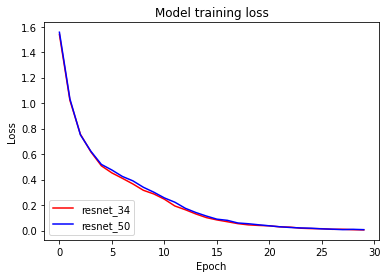

In [ ]:
import matplotlib.pyplot as plt

plt.plot(histoty_34.history['loss'], 'r')
plt.plot(histoty_50.history['loss'], 'b')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='lower left')
plt.show()

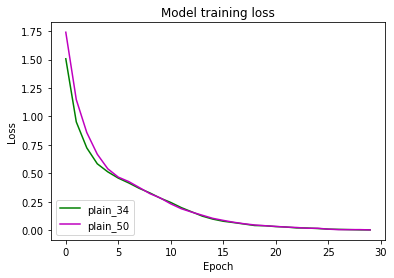

In [ ]:
plt.plot(histoty_plain_34.history['loss'],'g')
plt.plot(histoty_plain_50.history['loss'], 'm')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_34','plain_50'], loc='lower left')
plt.show()

# 검증 정확도

val_accuracy

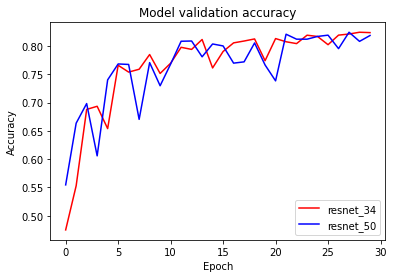

In [ ]:
plt.plot(histoty_34.history['val_accuracy'], 'r')
plt.plot(histoty_50.history['val_accuracy'], 'b')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='lower right')
plt.show()

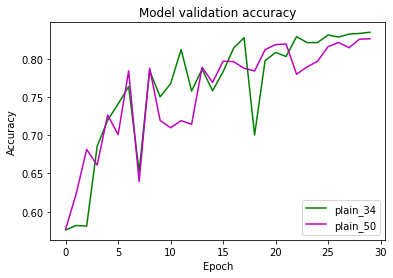

In [ ]:

plt.plot(histoty_plain_34.history['val_accuracy'],'g')
plt.plot(histoty_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_34','plain_50'], loc='lower right')
plt.show()

# 회고


시각화를 통해서 resnet 모델을 적용한 것과 그렇지 않은 것에 대해서 비교를 하였다.
에폭을 처음에는 15로 주었는데 plain 모델과 큰 차이를 못 느껴 30으로 수정해서 테스트하였다.
loss 값은 큰 의미있는 차이를 못 느꼈고, val_accuracy 값에서 resnet 모델을 사용하여 층을 쌓았을때 층이 깊을수록 정확도가 향상되는 것을 볼 수 있었다.
